In [22]:
from utils.FloorplanToBlenderLib import *
from PIL import Image
import cv2
import numpy as np
import pandas as pd
import math

In [24]:
def img_processing(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # convert to binary image & remove noise
    thresh = cv2.threshold(gray, 135, 255, cv2.THRESH_BINARY )[1]

    #  Morphological reconstruction (delete labels)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (7, 7))
    kernel2 = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    marker = cv2.dilate(thresh, kernel, iterations = 1)
    while True:
        tmp=marker.copy()
        marker=cv2.erode(marker, kernel2)
        marker=cv2.max(thresh, marker)
        difference = cv2.subtract(tmp, marker)
        if cv2.countNonZero(difference) == 0:
            break

    # only walls
    se = cv2.getStructuringElement(cv2.MORPH_RECT, (4, 4))
    walls = cv2.morphologyEx(marker, cv2.MORPH_CLOSE, se)
    walls = cv2.erode(walls, kernel2, iterations = 2)

    # other objects
    other = cv2.compare(marker,walls, cv2.CMP_GE)
    other = cv2.bitwise_not(other)
    return thresh, marker, walls, other


def get_median(data):
    # get median of elements width & height
    column_values = ['left', 'top', 'width', 'height', 'area']
    df = pd.DataFrame(data = data, columns = column_values)
    df = df[(df['width'] >= 10) & 
            (df['height'] >= 10) & 
            (df['width'] < 50) & 
            (df['height'] < 50)].sort_values(by='width', ascending=True)
    
    m_width = df['width'].median()
    m_height = df['height'].median()
    return m_width, m_height


def find_door(img):
    c_list = []
    
    thresh, marker, walls, other = img_processing(img)

    # find connected components and select by size and area
    output = cv2.connectedComponentsWithStats(other, 4, cv2.CV_32S)
    num_labels = output[0]
    labels = output[1]
    stats = output[2]
    centroids = output[3]
    
    m_width, m_height = get_median(stats)
    
    for i in range(num_labels):
        left, top, width, height, area = stats[i]
        if width > m_width - 10 and width < m_width + 10 and height > m_height - 10 and height < m_height + 10 and abs(width - height) < 15:
            # door gravity
            cx = round(left + width*0.5)
            cy = round(top + height*0.5) 
            c_list.append([cx, cy])

    return c_list


def check_rgb(img, coord):
    val = img[coord[1], coord[0]]  # img(y, x)
    
    # black -> False / others -> True
    return True if sum(val) else False


def check_intersection(img, p1, p2):
    dx = p1[0] - p2[0]
    dy = p1[1] - p2[1]
    
    
    # when y = 0
    if dx == 0:
        ang = 90
        x = p1[0]
        
        for y in range(p1[1], p2[1]):
            pt = [p1[0], y]
            # check if intersect wall
            if not check_rgb(img, pt):
                return False
    # when y != 0
    else:
        m = dy / dx  # get slope
        arc = math.atan(abs(m))  # get arc
        ang = (arc * 180) / math.pi  # get angle
        
        a = m
        b = p1[1] - (a * p1[0])

        # x-axis
        if ang < 6:
            if p1[0] > p2[0]:
                tmp = p1
                p1 = p2
                p2 = tmp
                
            for x in range(p1[0], p2[0]):
                y = round(a * x + b)
                pt = [x, y]
                if not check_rgb(img, pt):
                    return False

        # y-axis
        elif ang > 84:
            if p1[1] > p2[1]:
                tmp = p1
                p1 = p2
                p2 = tmp
                
            for y in range(p1[1], p2[1]):
                x = round((y - b) / a)
                pt = [x, y]
                
                if not check_rgb(img, pt):
                    return False
        else: return False
    
    return True
    
    
def check_FengShui(c_list, img):
    _, _, walls, _ = img_processing(img)
    walls = cv2.cvtColor(walls, cv2.COLOR_GRAY2BGR)
    
    for i in range(len(c_list) - 1):
        for j in range(i + 1, len(c_list)):
            if check_intersection(walls, c_list[i], c_list[j]):  # if true -> draw the line
                cv2.line(img, c_list[i], c_list[j], (0, 0, 255), 5)
                
    return img

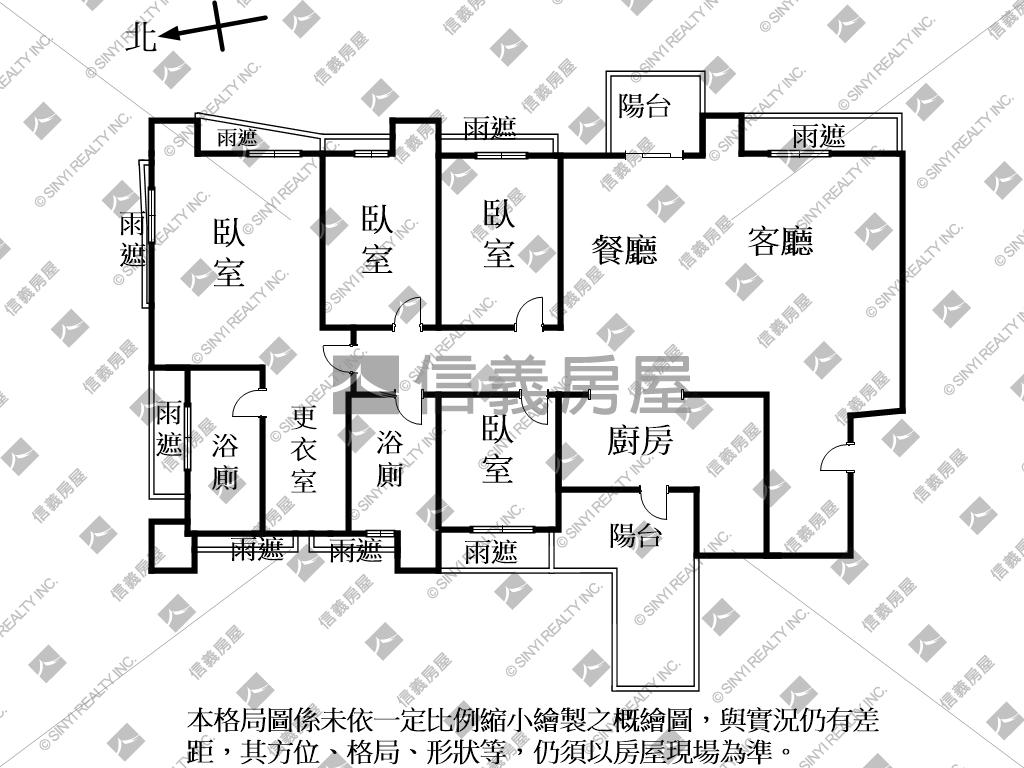

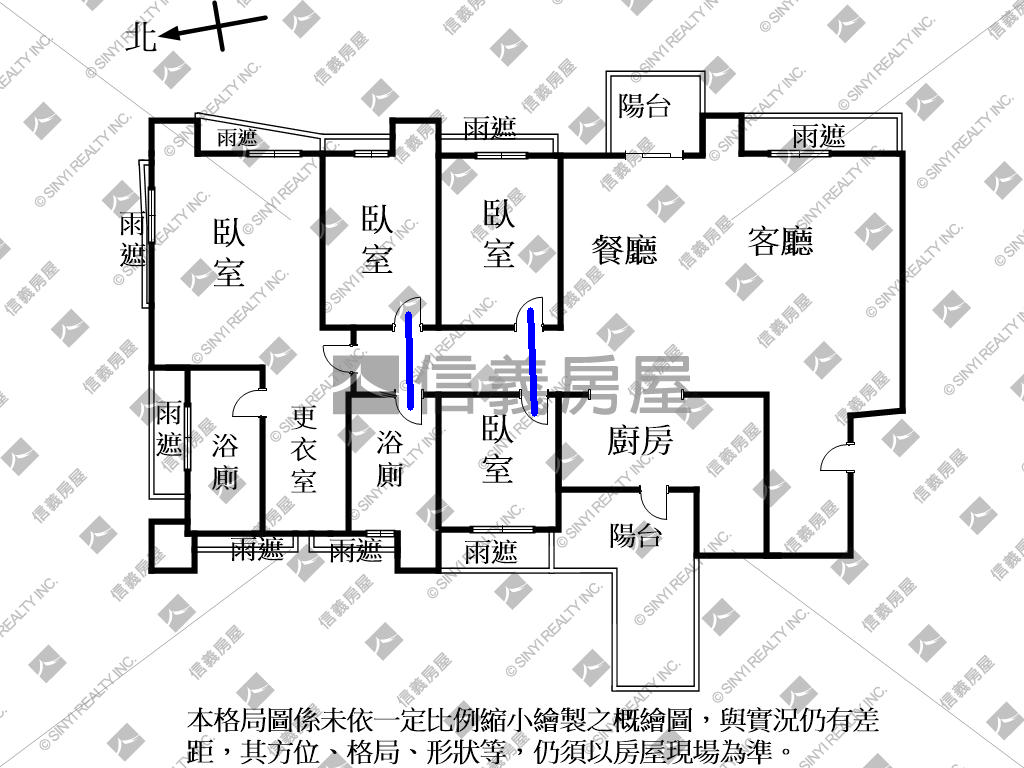

In [25]:
img = cv2.imread("images/30.jpg")
res_img = img.copy()

# get doors coordinate
c_list = find_door(img)

# check fengshui & draw the signal
res_img = check_FengShui(c_list, res_img)

display(Image.fromarray(img))
display(Image.fromarray(res_img))